#### NSBL: Two parameter case, sum of two gaussian kernels, multimodal evidence
##### - compare evidence calculation, analytical vs numerical
##### - plot posterior pdf, likelihood function and prior pdf for a given hyperparameter value

In [1]:
#!/usr/bin/python
import numpy as np
import numpy.linalg as la
import scipy.stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, math, sys
np.random.seed(88)
#os.system('rm *.pdf *.eps *.png');

In [2]:
K = 2 # number of kernels
Nphi = 2 # dimension of parameter space
aCoeff  = np.ones((1,K)) 
muVec  = np.zeros((Nphi,K))
SigMat = np.zeros((Nphi,Nphi,K))
rCoeff = 1e-04*np.ones((1,Nphi)) 
sCoeff = 1e-04*np.ones((1,Nphi))

In [3]:
rho = -0.9
var = 0.05
fac = 0.25
SigMat[:,:,0] = [[var,var*rho],[var*rho,var]]
SigMat[:,:,1] = [[fac*var,fac*var*rho],[fac*var*rho,fac*var]]
muVec[0,0] = 1.0
muVec[1,1] = 1.0

In [4]:
def NSBL(logalpIN):
    alp = np.exp(logalpIN)
    A = np.diag(alp)
    Ainv = np.diag(1/alp)
    Bmat = np.zeros((Nphi,Nphi,K))
    Pmat = np.zeros((Nphi,Nphi,K))
    mVec = np.zeros((Nphi,K))
    wVec = np.zeros((1,K))
    vVec = np.zeros((Nphi,K))
    vbarVec = np.zeros((Nphi,1))
    jVec = np.zeros((Nphi,1))
    Hmat = np.zeros((Nphi,Nphi))
    for k in range(0,K):
        Bmat[:,:,k] = SigMat[:,:,k] + Ainv
        Pmat[:,:,k] = Ainv - Ainv@la.inv(Bmat[:,:,k])@Ainv
        mVec[:,k]   = Pmat[:,:,k]@la.inv(SigMat[:,:,k])@muVec[:,k]
        wVec[0,k]   = aCoeff[0,k]*st.multivariate_normal.pdf(muVec[:,k],[0]*Nphi,Bmat[:,:,k])
        for ii in range(0,Nphi):
            vVec[ii,k] = 0.5*(1.0 - alp[ii]*(Pmat[ii,ii,k] + mVec[ii,k]**2))
    evid = np.sum(wVec)
    wVec = wVec/evid
    objFun = np.log(evid) + np.dot(rCoeff[0,:],logalpIN) - np.dot(sCoeff[0,:],alp)
    for ii in range(0,Nphi):
        vbarVec[ii,0] = np.dot(wVec[0,:],vVec[ii,:])
        jVec[ii,0]   = vbarVec[ii,0] + rCoeff[0,ii] - sCoeff[0,ii]*alp[ii]
        for jj in range(0,ii):
            Hmat[ii,jj] = Hmat[jj,ii]
        for jj in range(ii,Nphi):
            tmpij = 1.0 if ii==jj else 0.0
            for k in range(0,K):
                Hmat[ii,jj] = Hmat[ii,jj] + wVec[0,k]*(alp[ii]*alp[jj]*(0.5*Pmat[ii,jj,k]**2 \
                                    + mVec[ii,k]*mVec[jj,k]*Pmat[ii,jj,k]) \
                                    + vVec[jj,k]*(vVec[ii,k] - vbarVec[ii,0]))
            Hmat[ii,jj] = Hmat[ii,jj] + tmpij*(vbarVec[ii,0] - sCoeff[0,ii]*alp[ii] - 0.5)
    return np.log(evid), objFun, jVec[:,0], Hmat

In [5]:
def NSBLpoststat(xIN,logalpIN):
    alp = np.exp(logalpIN)
    A = np.diag(alp)
    Ainv = np.diag(1/alp)
    Bmat = np.zeros((Nphi,Nphi,K))
    Pmat = np.zeros((Nphi,Nphi,K))
    mVec = np.zeros((Nphi,K))
    wVec = np.zeros((1,K))
    PostPdf = 0.0
    LikFun = 0.0
    for i in range(0,K):
        Bmat[:,:,i] = SigMat[:,:,i] + Ainv
        Pmat[:,:,i] = Ainv - Ainv@la.inv(Bmat[:,:,i])@Ainv
        mVec[:,i]   = Pmat[:,:,i]@la.inv(SigMat[:,:,i])@muVec[:,i]
        wVec[0,i]= aCoeff[0,i]*st.multivariate_normal.pdf(muVec[:,i],[0]*Nphi,Bmat[:,:,i])
        LikFun  = LikFun  + aCoeff[0,i]*st.multivariate_normal.pdf(xIN,muVec[:,i],SigMat[:,:,i])
        PostPdf = PostPdf + wVec[0,i]*st.multivariate_normal.pdf(xIN,mVec[:,i],Pmat[:,:,i])  
    PriorPdf = st.multivariate_normal.pdf(xIN,[0]*Nphi,Ainv)
    return PriorPdf, LikFun, PostPdf

In [6]:
atLogAlp = np.array([2,2])
Ngrd  = 50
LFgrd = np.zeros((Ngrd,Ngrd))
PSgrd = np.zeros((Ngrd,Ngrd))
PRgrd = np.zeros((Ngrd,Ngrd))
checkLevid = np.zeros((Ngrd,Ngrd))
X1bnd = [-1,2]
X2bnd = [-1,2]
X1rng = np.linspace(X1bnd[0],X1bnd[1],Ngrd)
X2rng = np.linspace(X2bnd[0],X2bnd[1],Ngrd)
X1grd,X2grd = np.meshgrid(X1rng,X2rng)
for i in range(0,Ngrd):
    for j in range(0, Ngrd):
        Xcur = np.array([X1grd[i,j],X2grd[i,j]])
        PRgrd[i,j], LFgrd[i,j], PSgrd[i,j] = NSBLpoststat(Xcur,atLogAlp)
        checkLevid[i,j] =  LFgrd[i,j]*PRgrd[i,j]
LevidEst = np.log(np.sum(checkLevid)*(X1rng[1]-X1rng[0])*(X2rng[1]-X2rng[0]))

In [7]:
Levid, _,_,_ = NSBL(atLogAlp)
print('Numerical:  ',Levid,'\nAnalytical: ',LevidEst)

Numerical:   -2.4497150472482305 
Analytical:  -2.449713983462244


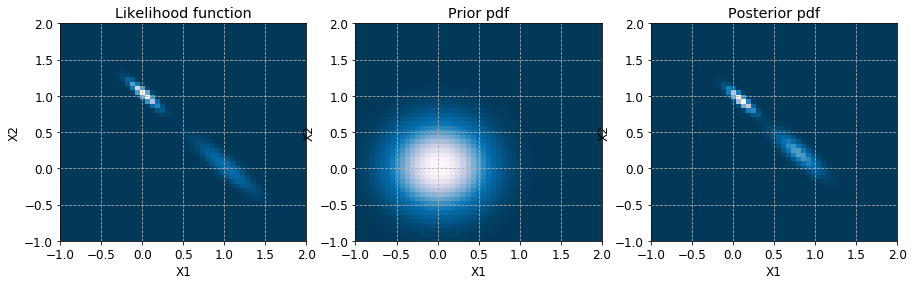

In [8]:
mpl.rcParams.update({'font.size':12})
fig=plt.figure(1,figsize=(15,4))
plt.subplot(1, 3, 1)
plt.pcolor(X1grd,X2grd,LFgrd,cmap='PuBu_r')
#plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Likelihood function')

plt.subplot(1, 3, 2)
plt.pcolor(X1grd,X2grd,PRgrd,cmap='PuBu_r')
#plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Prior pdf')

plt.subplot(1, 3, 3)
plt.pcolor(X1grd,X2grd,PSgrd,cmap='PuBu_r')
#plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Posterior pdf')
plt.savefig('plot_post.eps',bbox_inches='tight')